In [79]:
import torch
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [80]:
import json

# Load the label mapping
with open('./content/squeezenet-labels.json') as f:
    label_mapping = json.load(f)


In [81]:
model = models.squeezenet1_1(pretrained=True)

/home/highorder/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/highorder/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
# input_image = "./content/dog.png"  # Provide the path to your input image
# image = Image.open(input_image).convert("RGB")  # Convert image to RGB format
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def reverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Reverse the normalization of a tensor.
    
    Args:
    - tensor (torch.Tensor): The normalized tensor.
    - mean (list): The mean used for normalization.
    - std (list): The standard deviation used for normalization.
    
    Returns:
    - torch.Tensor: The unnormalized tensor.
    """
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return tensor * std + mean

# processed_image = preprocess(image).unsqueeze(0)



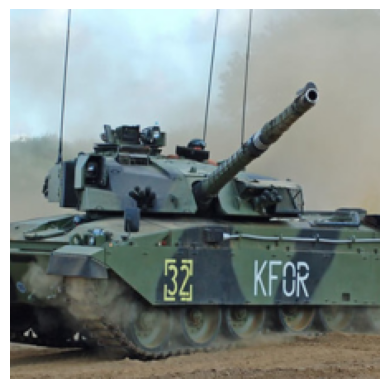

In [83]:
path = './data/imagenet/847'
#todo, add new classes other then tanks
# Load all images in the folder and convert them to RGB
import os
image_paths = [os.path.join(path, img) for img in os.listdir(path) if img.endswith('.jpg')]
images = [Image.open(img_path).convert("RGB") for img_path in image_paths]
images_other = [Image.open(img_path).convert("RGB") for img_path in image_paths]

images = [preprocess(image).unsqueeze(0) for image in images]


# Reverse normalize the image
unnormalized_image = reverse_normalize(images[0]).squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

# Display the image
plt.imshow(unnormalized_image)
plt.axis('off')
plt.show()

In [84]:
def show_image_label(image, label):
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

def print_top_predictions(output, label_mapping, top_k=5):
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    top5_prob, top5_catid = torch.topk(probabilities, top_k)

    print("Top 5 Predictions:")
    for i in range(top5_prob.size(0)):
        label = label_mapping[str(top5_catid[i].item())]
        percentage = top5_prob[i].item() * 100
        print(f'{label}: {percentage:.2f}%')

def show_image_and_predictions(image, output, label_mapping, top_k=5):
    # Check if the image has 4 dimensions and squeeze if necessary
    if image.dim() == 4:
        image = image.squeeze(0)
    
    # Show the image
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    
    # Get the top predictions
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    #probabilities.shape = [1000]
    # its a estiamte of likelihood of each of the 1000 classes

    top5_prob, top5_catid = torch.topk(probabilities, top_k)
    # shape = [5] they are 5 rank 1 tensors each
    
    # Print the top predictions
    print_top_predictions(output, label_mapping, top_k)

    return probabilities




In [85]:
def attack_BIM(mean, std, model, image, class_index, epsilon, alpha, num_iterations=10):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    mean           -- Mean from data preparation
    std            -- Standard deviation from data preparation
    model          -- Network under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    class_index    -- Label from image as numpy array   
    epsilon        -- Hyperparameter for sign method. Has to be scaled to epsilon/255
    alpha          -- Hyperparameter for iterative step as absolute value. Has to be scaled to alpha/255
    num_iterations -- Number of iterations to perform. Default is 10. It is recommended to use the heuristic from the
                      paper "Adversarial Examples in the Pysical World" to determine the number of iterations
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''

    # Convert label to torch tensor of shape (1)
    class_index = torch.tensor([class_index])

    # Check input image and label shapes
    assert(image.shape == torch.Size([1, 3, 224, 224]))
    assert(class_index.shape == torch.Size([1]))
    
    # Initialize adversarial image as image according to equation 2.1
    image_adver = image.clone()    
    
    # Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    # Calculate normalized alpha
    alpha_normed = [alpha/s for s in std]
    alpha_normed = torch.tensor(alpha_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)

    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    # Calculate the maximum change in pixel value using epsilon to be later used in clip function
    image_plus = image + eps_normed
    image_minus = image - eps_normed
    
    for i in range(num_iterations):
        
        # Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        image_adver.requires_grad=True
        
        # Compute cost with example image_adversarial        
        pred = model(image_adver)        
        loss = F.nll_loss(pred, class_index)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       
        
        # Check if gradient exists
        assert(image_adver.grad is not None)
               
        # Compute X_prime according to equation 2.2
        image_prime = image_adver + alpha_normed * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
      
        # Equation 2.3 part 1
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(zero_normed, third_part_1)
              
        # Equation 2.3 part 2
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(max_normed, image_adver)                        

    return image_adver

In [86]:
import torch.nn.functional as F


In [87]:

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
epsilon = 0.025
alpha = 0.01
num_iterations = 10
class_index = torch.tensor([847])  # Example class index




# Create a list of adversarial images
adversarial_images = [attack_BIM(mean, std, model, img, class_index, epsilon, alpha, num_iterations) for img in images]


In [88]:
adversarial_images_unnormalized = [reverse_normalize(img) for img in adversarial_images]


## class based processing

In [89]:
class ImageProcessor:
    def __init__(self, images):
        self.images = images
        self.processed_images = []
        self.adversarial_images = []
        self.adversarial_images_unnormalized = []

    def process_images(self):
        self.processed_images = [preprocess(image).unsqueeze(0) for image in self.images]

    def attack_BIM_all(self, mean, std, model, class_index, epsilon, alpha, num_iterations=10):
        if not self.processed_images:
            raise ValueError("Images need to be processed first.")
        self.adversarial_images = [attack_BIM(mean, std, model, img, class_index, epsilon, alpha, num_iterations) for img in self.processed_images]

    def unnormalize_adversarial(self):
        if not self.adversarial_images:
            raise ValueError("Adversarial images need to be generated first.")
        self.adversarial_images_unnormalized = [reverse_normalize(img) for img in self.adversarial_images]

    def display_first_image(self):
        if not self.processed_images:
            raise ValueError("Images need to be processed first.")
        first_processed_image = self.processed_images[0]
        plt.imshow(reverse_normalize(first_processed_image).squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("First Processed Image")
        plt.show()



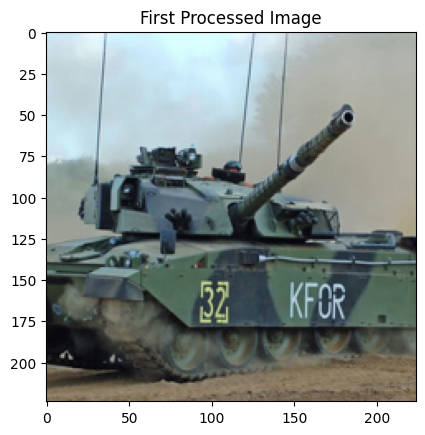

In [90]:
tank_images = ImageProcessor(images_other)
tank_images.process_images()
tank_images.display_first_image()


## individual data explore

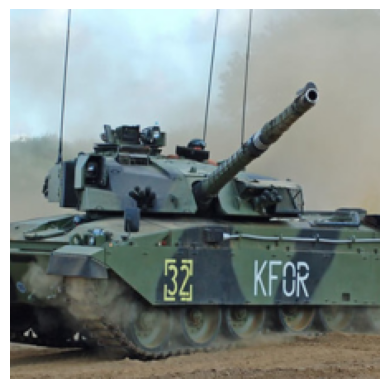

Top 5 Predictions:
tank, army tank, armored combat vehicle, armoured combat vehicle: 98.29%
amphibian, amphibious vehicle: 1.06%
trimaran: 0.26%
catamaran: 0.14%
warplane, military plane: 0.12%


In [97]:
ori_image, adv_image = images[0], adversarial_images[0]

a= show_image_and_predictions(reverse_normalize(ori_image), model(ori_image), label_mapping, top_k=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


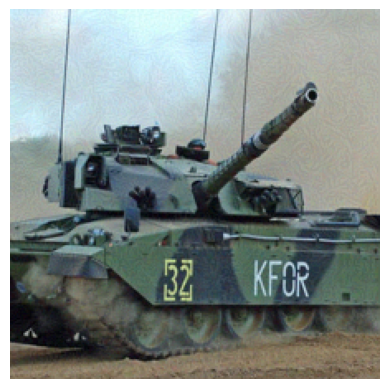

Top 5 Predictions:
paper towel: 19.30%
toilet tissue, toilet paper, bathroom tissue: 15.80%
plastic bag: 5.37%
sweatshirt: 4.97%
soccer ball: 3.42%


In [98]:
a = show_image_and_predictions(reverse_normalize(adv_image), model(adv_image), label_mapping, top_k=5)

In [93]:
import math

def calculate_percentage_difference(mse, num_channels=3, max_pixel_value=255):
    """
    Calculate the average percentage difference between two images based on the Mean Squared Error (MSE),
    taking into account multiple color channels.

    Parameters:
    mse (float): The Mean Squared Error between two images.
    num_channels (int): The number of color channels (default is 3 for RGB images).
    max_pixel_value (int): The maximum possible pixel value (default is 255 for 8-bit images).

    Returns:
    float: The average percentage difference between the two images.
    """
    # Calculate the average MSE per channel
    mse_per_channel = mse / num_channels
    
    # Calculate the average absolute difference per channel
    average_difference_per_channel = math.sqrt(mse_per_channel)
    
    # Calculate the percentage change per channel
    percentage_change_per_channel = (average_difference_per_channel / max_pixel_value) * 100
    
    return percentage_change_per_channel

In [94]:
# Calculate the difference and give a numerical value

# Difference between ori_image and adv_image
diff1 = torch.sum((ori_image - adv_image) ** 2).item()
print(f"Difference between ori_image and adv_image: {diff1}")

# Difference between reverse_normalize(ori_image) and adv_image_unnormalized
diff2 = torch.sum((reverse_normalize(ori_image) - reverse_normalize(adv_image)) ** 2).item()
print(f"Difference between reverse_normalize(ori_image) and adv_image_unnormalized: {diff2}")

percentage_difference = calculate_percentage_difference(diff2)
print(f"Average percentage difference: {percentage_difference:.2f}%")

Difference between ori_image and adv_image: 858.4141845703125
Difference between reverse_normalize(ori_image) and adv_image_unnormalized: 43.8324089050293
Average percentage difference: 1.50%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

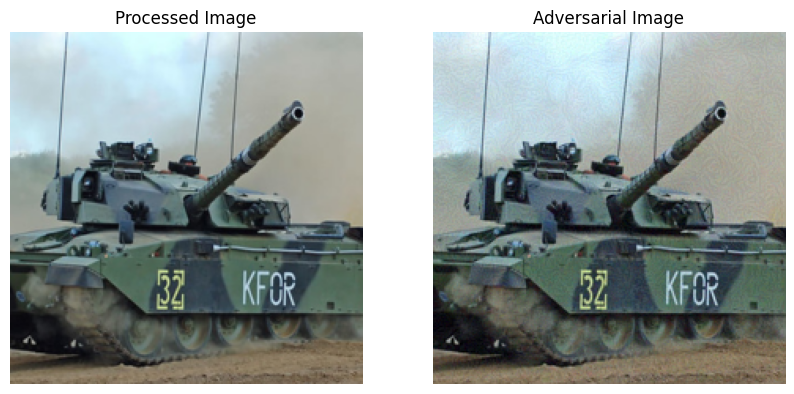

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot processed_image
axes[0].imshow(reverse_normalize(ori_image).squeeze().permute(1, 2, 0).cpu().detach().numpy())
axes[0].set_title('Processed Image')
axes[0].axis('off')

# Plot adversarial_image
axes[1].imshow(reverse_normalize(adv_image).squeeze().permute(1, 2, 0).cpu().detach().numpy())
axes[1].set_title('Adversarial Image')
axes[1].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


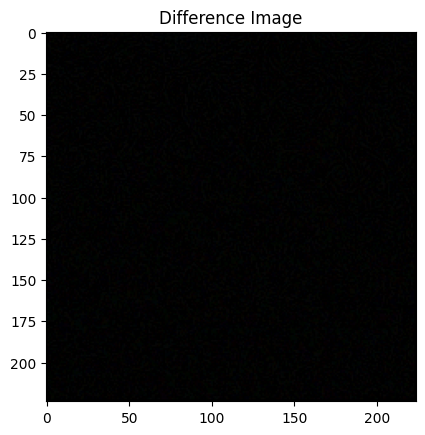

In [96]:
difference_image = (reverse_normalize(ori_image) - reverse_normalize(adv_image)).squeeze(0)
squared_difference_image = difference_image ** 2
# Plot the resulting difference
plt.imshow(difference_image.permute(1, 2, 0).cpu().detach().numpy())
plt.title('Difference Image')
plt.show()